# Drive & Environment Setup

In [1]:
IN_COLAB = False

try:
  import google.colab
  IN_COLAB = True
except:
  pass

if IN_COLAB == True:
  from google.colab import drive
  drive.mount('/content/gdrive')
  %cd /content/gdrive/MyDrive/Tesi_GDrive
  PROJECT_PATH = '/content/gdrive/MyDrive/Tesi_GDrive'
  #!ls
else:
  %cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
  PROJECT_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os

if IN_COLAB == True:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))
else:
  sys.path.insert(0, os.path.abspath('functions'))
  sys.path.insert(0, os.path.abspath(''))

warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from keras.models import Sequential, Model
from keras.layers import Dense, Lambda
from keras.layers import Activation
from keras.activations import exponential, relu
from keras import backend as K
import tensorflow as tf
#from tensorflow.keras.layers import Input, Layer, InputSpec, Reshape
#from tensorflow.keras import initializers
#from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
from scipy.optimize import minimize, differential_evolution

from pkl import store_data, load_data
#from functions.compressor import compress
from functions.compressor_param import compress_2
from functions.mapping import ind2sub, sub2ind3d

import random
from collections import defaultdict

from math import log

import re
import time

print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-06-29 21:11:46.171295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


# Data Import

In [2]:
cta30_def_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')  
df_def = pd.read_csv(cta30_def_path)


cta30_18_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
cta30_19_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
cta30_20_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
cta30_21_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
cta30_22_path = os.path.join(PROJECT_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')

df18= pd.read_csv(cta30_18_path)
df19= pd.read_csv(cta30_19_path)
df20= pd.read_csv(cta30_20_path)
df21= pd.read_csv(cta30_21_path)
df22= pd.read_csv(cta30_22_path)

df_complete = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

#drop le colonne 'F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00' 
df = df_complete.drop(['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)
# create df_a with only dropped columns
df_a = df_complete[['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00']]

[r,c] = df.shape
print("The dataset has", r, "rows and", c, "columns")



The dataset has 2176378 rows and 73 columns


# Data Preprocessing - "Compression"

## Normalization

In [4]:
path_scale_norm = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/scaler_norm.pkl'
try: 
    scale_norm = load_data(path_scale_norm)
    df_norm = pd.DataFrame(scale_norm.transform(df), columns=df.columns)
except:
    scale_norm = MinMaxScaler()
    df_norm = pd.DataFrame(scale_norm.fit_transform(df), columns=df.columns)
    store_data(scale_norm, path_scale_norm)

print("The dataset has", df_norm.shape[1], "columns after normalization")

path_pca_norm = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/pca_norm_09.pkl'

try:
    pca = load_data(path_pca_norm)
    df_pca = pd.DataFrame(pca.transform(df_norm), columns=df_norm.columns)
    print("PCA loaded")
except:
    print("Computing PCA")
    pca = PCA(n_components=0.9)
    df_pca = pd.DataFrame(pca.fit_transform(df_norm))
    store_data(pca, path_pca_norm)
    print("PCA computed")
print("The dataset has", df_pca.shape[1], "columns after PCA")

df_a_norm = pd.DataFrame(scale_norm.fit_transform(df_a), columns=df_a.columns)


The dataset has 73 columns after normalization
Computing PCA
PCA computed
The dataset has 7 columns after PCA


## Standardization

In [5]:
path_scale_st = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/scaler_st.pkl'
try: 
    scale_st = load_data(path_scale_st)
    df_st= pd.DataFrame(scale_st.transform(df), columns=df.columns)
except:
    scale_st = MinMaxScaler()
    df_st = pd.DataFrame(scale_st.fit_transform(df), columns=df.columns)
    store_data(scale_st, path_scale_st)

path_pca_st = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/pca_stpkl'
try:
    pca = load_data(path_pca_st)
    df_pca = pd.DataFrame(pca.transform(df_st), columns=df_st.columns)
except:
    pca = PCA(n_components=0.9)
    df_pca = pd.DataFrame(pca.fit_transform(df_st))
    store_data(pca, path_pca_st)
print("The dataset has", df_pca.shape[1], "columns after PCA")

df_a_st = pd.DataFrame(scale_st.fit_transform(df_a), columns=df_a.columns)




The dataset has 7 columns after PCA


# Data Preprocessing - "Clustering"

## K-Means

### Stato

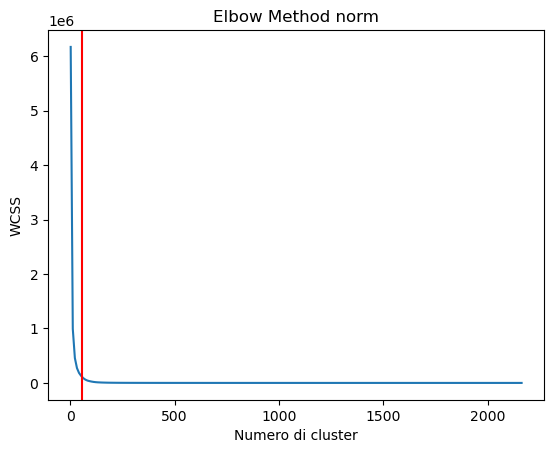

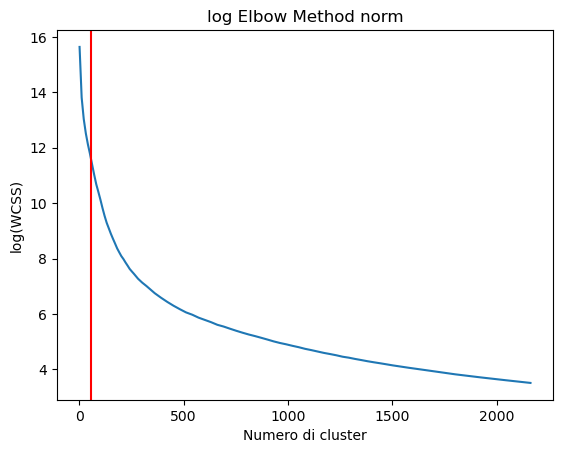

In [25]:
# ELBOW graph

from math import log

path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_norm'
file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    numero = int(nome_file.split("_")[1].split(".")[0])
    return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)


x = []
y = []

X = pca_norm

for i in range(len(file_list_ordinata)):

    # carica il file pkl
    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)
    
    #esegui la fit su pca_norm 
    #modello.fit(X)

    #assegna alla variabile x il numero di cluster
    x.append(modello.n_clusters)

    #assegna alla variabile y il valore di wcss 
    y.append(modello.inertia_)

elbow = 55
plt.plot(x,y)
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm')
plt.show()

plt.plot(x,[log(i) for i in y])
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('log(WCSS)')
plt.title('log Elbow Method norm')
plt.show()


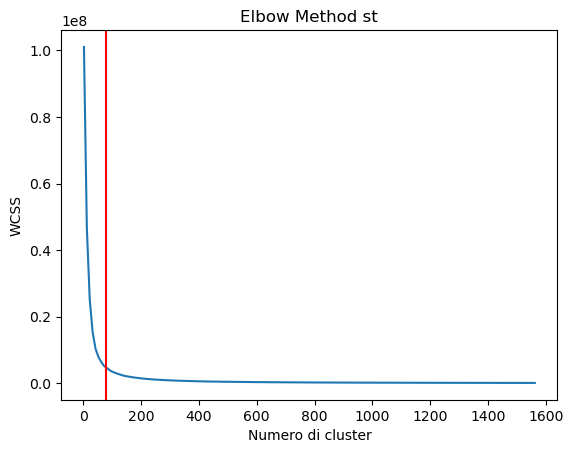

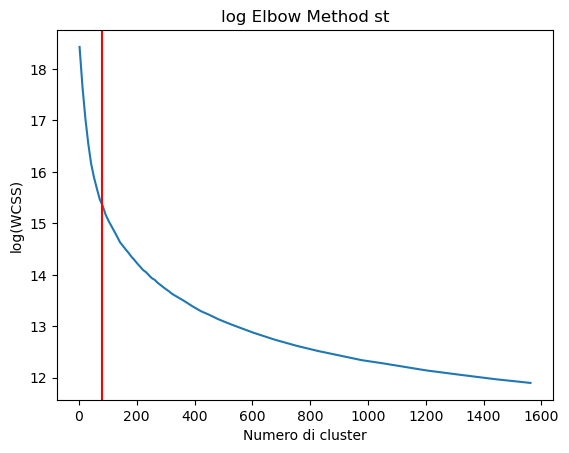

In [49]:
from math import log

path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_st'
file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    numero = int(nome_file.split("_")[1].split(".")[0])
    return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)



x = []
y = []

X = pca_st

for i in range(len(file_list_ordinata)):

    # carica il file pkl
    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)
    
    #esegui la fit su pca_norm 
    #modello.fit(X)

    #assegna alla variabile x il numero di cluster
    x.append(modello.n_clusters)

    #assegna alla variabile y il valore di wcss 
    y.append(modello.inertia_)

elbow = 80
plt.plot(x,y)
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method st')
plt.show()

plt.plot(x,[log(i) for i in y])
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.xlabel('Numero di cluster')
plt.ylabel('log(WCSS)')
plt.title('log Elbow Method st')
plt.show()


### Azione

#### Clustering Completo su Azioni

In [19]:
X = df_a_norm
k_min = 2
k_max = 10
step = 1
folder_name = 'fit_norm_a'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    if os.path.isfile(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl'):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X)
        with open(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")



kmeans_2.pkl already exists
kmeans_3.pkl already exists
kmeans_4.pkl already exists
kmeans_5.pkl already exists
kmeans_6.pkl already exists
kmeans_7.pkl already exists
kmeans_8.pkl already exists
kmeans_9.pkl already exists
kmeans_10.pkl already exists


In [9]:

#for each kmeans_i in folder fit_norm_a compute the elbow method
path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_norm_a'
file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    #se il file inizia con kmeans_
    if nome_file.startswith("kmeans_"):
        numero = int(nome_file.split("_")[1].split(".")[0])
        return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

#crea una lista vuota per i valori di wcss
wcss = []

#carica i pkls e calcola il wcss
for i in range(len(file_list_ordinata)):

    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)

    wcss.append(modello.inertia_)

kmeans_nums = []
for file in file_list:
    match = re.search("kmeans_(\d+)\.pkl", file)
    if match:
        kmeans_num = int(match.group(1))
        kmeans_nums.append(kmeans_num)

#sort the list kmeans_nums
kmeans_nums.sort()
print('kmeans_nums', (kmeans_nums))
print('wcss shape:', len(wcss))

plt.plot(kmeans_nums, wcss)
#plot a red vertical line at the elbow
plt.axvline(x=8, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm_a')
plt.show()

#plot the log of wcss
plt.plot(kmeans_nums, [log(i) for i in wcss])
#plot a red vertical line at the elbow
plt.axvline(x=8, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('log(WCSS)')
plt.title('log Elbow Method norm_a')
plt.show()

TypeError: '<' not supported between instances of 'NoneType' and 'int'

### Clusterin Su 3 Azioni

##### A1

In [14]:
X1 = df_a_norm['F_M_FDBK_00'].values.reshape(-1,1)
k_min = 2
k_max = 10
step = 1
folder_name = 'fit_norm_a/a1'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    if os.path.isfile(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl'):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X1)
        with open(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")

kmeans_2.pkl already exists
kmeans_3.pkl already exists
kmeans_4.pkl already exists
kmeans_5.pkl already exists
kmeans_6.pkl already exists
kmeans_7.pkl already exists
kmeans_8.pkl already exists
kmeans_9.pkl already exists
kmeans_10.pkl already exists


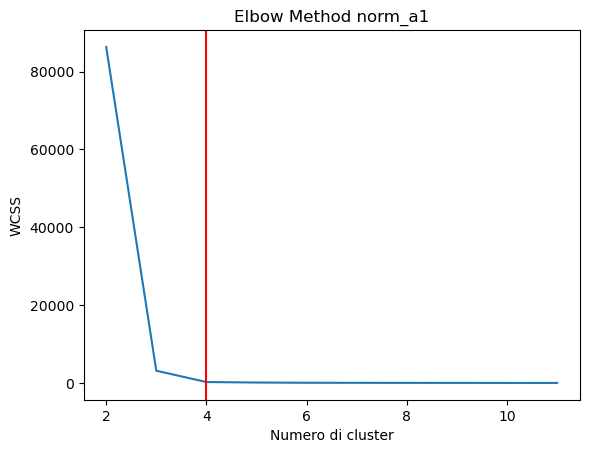

In [11]:
#for each kmeans_i in folder fit_norm_a compute the elbow method
path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_norm_a/a1'
file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    numero = int(nome_file.split("_")[1].split(".")[0])
    return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

#crea una lista vuota per i valori di wcss
wcss = []

#carica i pkls e calcola il wcss
for i in range(len(file_list_ordinata)):

    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)

    wcss.append(modello.inertia_)

kmeans_nums = []
for file in file_list:
    match = re.search("kmeans_(\d+)\.pkl", file)
    if match:
        kmeans_num = int(match.group(1))
        kmeans_nums.append(kmeans_num)

#sort the list kmeans_nums
kmeans_nums.sort()


plt.plot(kmeans_nums, wcss)
#plot a red vertical line at the elbow
plt.axvline(x=4, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm_a1')
plt.show()


##### A2

In [15]:
X2 = df_a_norm['VLV_RAF_REG_00'].values.reshape(-1,1)
k_min = 2
k_max = 10
step = 1
folder_name = 'fit_norm_a/a2'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    if os.path.isfile(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl'):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X2)
        with open(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")

kmeans_2.pkl already exists
kmeans_3.pkl already exists
kmeans_4.pkl already exists
kmeans_5.pkl already exists
kmeans_6.pkl already exists
kmeans_7.pkl already exists
kmeans_8.pkl already exists
kmeans_9.pkl already exists
kmeans_10.pkl already exists


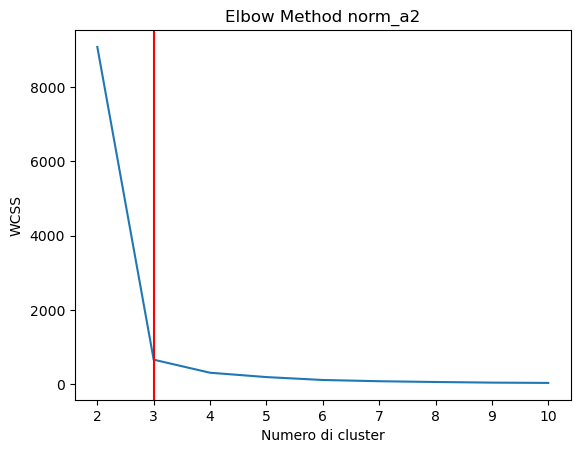

In [12]:
#for each kmeans_i in folder fit_norm_a compute the elbow method
path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_norm_a/a2'
file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    numero = int(nome_file.split("_")[1].split(".")[0])
    return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

#crea una lista vuota per i valori di wcss
wcss = []

#carica i pkls e calcola il wcss
for i in range(len(file_list_ordinata)):

    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)

    wcss.append(modello.inertia_)

kmeans_nums = []
for file in file_list:
    match = re.search("kmeans_(\d+)\.pkl", file)
    if match:
        kmeans_num = int(match.group(1))
        kmeans_nums.append(kmeans_num)

#sort the list kmeans_nums
kmeans_nums.sort()

plt.plot(kmeans_nums, wcss)
#plot a red vertical line at the elbow
plt.axvline(x=3, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm_a2')
plt.show()

##### A3

In [16]:
X3 = df_a_norm['VLV_SUR_REG_00'].values.reshape(-1,1)
k_min = 2
k_max = 10
step = 1
folder_name = 'fit_norm_a/a3'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    if os.path.isfile(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl'):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X3)
        with open(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/{folder_name}/kmeans_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")

kmeans_2.pkl already exists
kmeans_3.pkl already exists
kmeans_4.pkl already exists
kmeans_5.pkl already exists
kmeans_6.pkl already exists
kmeans_7.pkl already exists
kmeans_8.pkl already exists
kmeans_9.pkl already exists
kmeans_10.pkl already exists


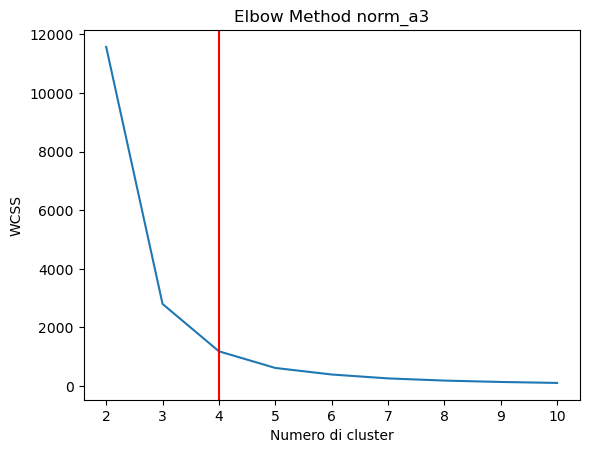

In [26]:
#for each kmeans_i in folder fit_norm_a compute the elbow method
path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_norm_a/a3'
file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    numero = int(nome_file.split("_")[1].split(".")[0])
    return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

#crea una lista vuota per i valori di wcss
wcss = []

#carica i pkls e calcola il wcss
for i in range(len(file_list_ordinata)):

    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)

    wcss.append(modello.inertia_)

kmeans_nums = []
for file in file_list:
    match = re.search("kmeans_(\d+)\.pkl", file)
    if match:
        kmeans_num = int(match.group(1))
        kmeans_nums.append(kmeans_num)

#sort the list kmeans_nums
kmeans_nums.sort()

plt.plot(kmeans_nums, wcss)
#plot a red vertical line at the elbow
plt.axvline(x=4, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm_a3')
plt.show()

## Agglomerative

### Azione

In [66]:
X = df_a_norm
k_min = 2
k_max = 10
step = 1
folder_name = 'fit_norm_a'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
    if os.path.isfile(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/agglomerative/{folder_name}/agglomerative_{n_clusters}.pkl'):
        print(f'Agglomerative_{n_clusters}.pkl already exists')
    else:
        agglomerative.fit(X)
        with open(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/agglomerative/{folder_name}/agglomerative_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(agglomerative, f)
        time_elapsed = time.time() - time_start
        print("Agglomerative with", n_clusters, "clusters computed in", time_elapsed, "seconds")

agglomerative_nums [2, 3, 4, 5, 6, 7, 8, 9, 10]
wcss shape: 9


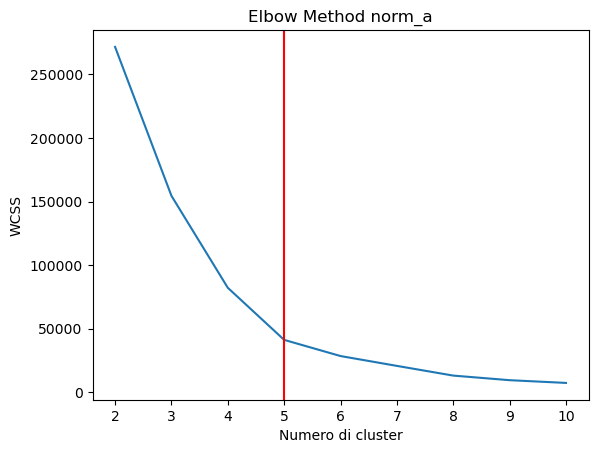

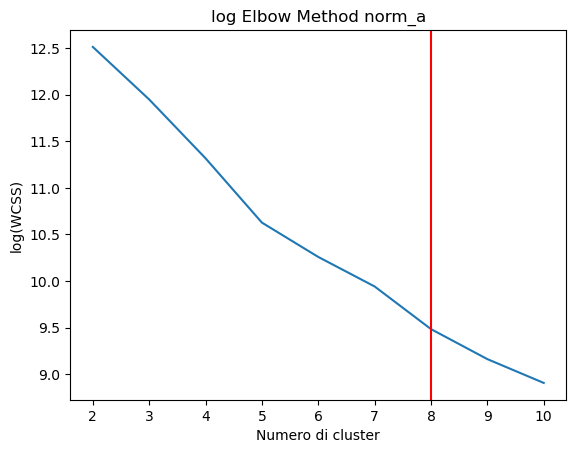

In [56]:

#for each kmeans_i in folder fit_norm_a compute the elbow method
path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/agglomerative/fit_norm_a'
file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    #se il file inizia con kmeans_
    if nome_file.startswith("agglomerative_"):
        numero = int(nome_file.split("_")[1].split(".")[0])
        return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

#crea una lista vuota per i valori di wcss
wcss = []

#carica i pkls e calcola il wcss
for i in range(len(file_list_ordinata)):

    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)

    wcss.append(modello.inertia_)

kmeans_nums = []
for file in file_list:
    match = re.search("agglomerative_(\d+)\.pkl", file)
    if match:
        kmeans_num = int(match.group(1))
        kmeans_nums.append(kmeans_num)

#sort the list kmeans_nums
kmeans_nums.sort()
print('agglomerative_nums', (kmeans_nums))
print('wcss shape:', len(wcss))

plt.plot(kmeans_nums, wcss)
#plot a red vertical line at the elbow
plt.axvline(x=5, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm_a')
plt.show()



## KMedoids

### Azione

In [4]:
X = df_a_norm
k_min = 2
k_max = 10
step = 1
folder_name = 'fit_norm_a'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMedoids(n_clusters=(n_clusters), init='k-medoids++', max_iter=300, n_init=10, random_state=0)
    if os.path.isfile(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/agglomerative/{folder_name}/agglomerative_{n_clusters}.pkl'):
        print(f'Agglomerative_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X)
        with open(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/agglomerative/{folder_name}/agglomerative_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("Agglomerative with", n_clusters, "clusters computed in", time_elapsed, "seconds")

NameError: name 'df_a_norm' is not defined

NameError: name 'df_a_norm' is not defined

In [ ]:

#crea una lista vuota per i valori di wcss
wcss = []

#carica i pkls e calcola il wcss
for i in range(len(file_list_ordinata)):

    with open(os.path.join(path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)

    wcss.append(modello.inertia_)

gm_nums = []
for file in file_list:
    match = re.search("gaussianmixtures_(\d+)\.pkl", file)
    if match:
        gm_nums = int(match.group(1))
        gm_nums.append(gm_nums)

#sort the list kmeans_nums
gm_nums.sort()
print('gaussian_mixtures_nums', (gm_nums))
print('wcss shape:', len(wcss))

plt.plot(gm_nums, wcss)
#plot a red vertical line at the elbow
plt.axvline(x=8, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm_a')
plt.show()


## Gaussian Mixture

### Azioni

In [ ]:
X = df_a_norm
k_min = 2
k_max = 10
step = 1
folder_name = 'fit_norm_a'

n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMedoids(n_clusters=(n_clusters), init='k-medoids++', max_iter=300, n_init=10, random_state=0)
    if os.path.isfile(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/agglomerative/{folder_name}/agglomerative_{n_clusters}.pkl'):
        print(f'Agglomerative_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X)
        with open(f'/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/agglomerative/{folder_name}/agglomerative_{n_clusters}.pkl', 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("Agglomerative with", n_clusters, "clusters computed in", time_elapsed, "seconds")

In [11]:
from sklearn.metrics import silhouette_score, silhouette_samples

X = df_a_norm

#for each kmeans_i in folder fit_norm_a compute the elbow method
path = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/gaussian_mixtures/fit_norm_a'
file_list = os.listdir(path)

# funzione personalizzata per l'ordinamento
def ordina_file_per_numero(nome_file):
    #se il file inizia con gaussian_mixtures_
    if nome_file.startswith("gaussianmixtures_"):
        numero = int(nome_file.split("_")[1].split(".")[0])
        return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)
file_path_complete = [os.path.join(path, file) for file in file_list_ordinata]

# Crea un grafico a barre per i punteggi di silhouette
fig = plt.figure(figsize=(10, len(file_list_ordinata)*2))
for i, file_name in enumerate(file_path_complete):
    with open(file_name, 'rb') as f:
        modello = pickle.load(f)
        labels = modello.predict(X)
        score = silhouette_score(X, labels)
        sample_scores = silhouette_samples(X, labels)
        ax = fig.add_subplot(len(file_list_ordinata), 1, i+1)
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([0, len(X) + (len(modello.means_)+1)*10])
        ax.set_title('Modello {}: Silhouette score = {:.2f}'.format(file_name, score))
        y_lower = 10
        for j in range(len(modello.means_)):
            jth_cluster_sample_scores = sample_scores[labels == j]
            jth_cluster_sample_scores.sort()
            size_cluster_j = jth_cluster_sample_scores.shape[0]
            y_upper = y_lower + size_cluster_j
            color = plt.cm.nipy_spectral(float(j) / len(modello.means_))
            ax.fill_betweenx(np.arange(y_lower, y_upper),
                              0, jth_cluster_sample_scores,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ax.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
            y_lower = y_upper + 10
        ax.axvline(x=score, color='red', linestyle='--')
        ax.set_yticks([])

plt.show()

KeyboardInterrupt: 

<Figure size 1000x1800 with 0 Axes>

# Model Generation

## Clustering Generation

In [59]:

with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_norm/kmeans_422.pkl', 'rb') as f:
    clustering_model = pickle.load(f)

with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/agglomerative/fit_norm_a/agglomerative_5.pkl', 'rb') as f:
    clustering_model_actions = pickle.load(f)
    print("centroids: \n",clustering_model_actions.cluster_centers_)
with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_norm_a/a1/kmeans_4.pkl', 'rb') as f:
    clustering_model_a1 = pickle.load(f)
    print("centroids a1: \n",clustering_model_a1.cluster_centers_)
with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_norm_a/a2/kmeans_3.pkl', 'rb') as f:
    clustering_model_a2 = pickle.load(f)
    print("centroids a2: \n",clustering_model_a2.cluster_centers_)
with open('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/fit_norm_a/a3/kmeans_4.pkl', 'rb') as f:
    clustering_model_a3 = pickle.load(f)
    print("centroids a3: \n",clustering_model_a3.cluster_centers_)


centroids: 
 [[ 9.96616573e-01  1.06659222e-02  6.74314646e-03]
 [ 9.00986952e-06  4.71944029e-06  1.95667301e-05]
 [ 4.73499288e-01  3.11591366e-02  3.60271081e-02]
 [ 5.96076989e-01  1.77023993e-04  9.18031440e-01]
 [ 7.35514074e-01  9.54943991e-01 -1.50018886e-14]]
centroids a1: 
 [[9.59514073e-06]
 [4.96453165e-01]
 [9.96612063e-01]
 [3.39540659e-01]]
centroids a2: 
 [[7.65558596e-05]
 [9.84479599e-01]
 [4.11893511e-01]]
centroids a3: 
 [[2.85004940e-01]
 [4.77590555e-04]
 [9.84340863e-01]
 [5.79721596e-01]]


In [61]:

X = pca_norm
df_pos = df_norm
XX = df_a_norm
name_clustering_model = 'kmeans_norm_c_a'
path_save_matrix = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans'


# create a empty df with 3 columns 
df_actions = pd.DataFrame(columns=['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00'])
df_actions['F_M_FDBK_00'] = clustering_model_a1.predict(X1)
df_actions['VLV_RAF_REG_00'] = clustering_model_a2.predict(X2)
df_actions['VLV_SUR_REG_00'] = clustering_model_a3.predict(X3)

labels = clustering_model.predict(X)
df_pos['cluster'] = labels

labels_actions = clustering_model_actions.predict(XX)
df_pos['action_clustered'] = labels_actions





In [64]:
#create a new df called df_mdp_norm with columns S, At, A1, A2, A3 
df_mdp_norm = pd.DataFrame(columns=['S', 'At', 'A1', 'A2', 'A3'])
df_mdp_norm['S'] = df_pos['cluster']
df_mdp_norm['At'] = df_pos['action_clustered']
df_mdp_norm['A1'] = df_actions['F_M_FDBK_00']
df_mdp_norm['A2'] = df_actions['VLV_RAF_REG_00']
df_mdp_norm['A3'] = df_actions['VLV_SUR_REG_00']

#save df_mdp_norm as csv
df_mdp_norm.to_csv('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/agglomerative/df_mdp_norm_422.csv', index=False)

In [23]:
print(df_mdp_norm['At'].max())

7


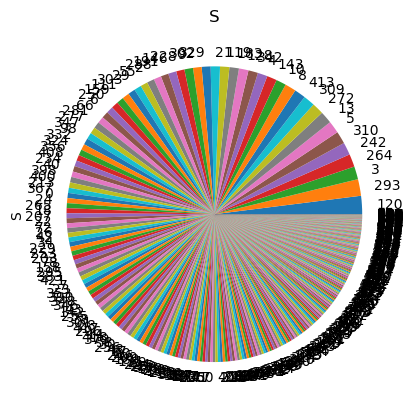

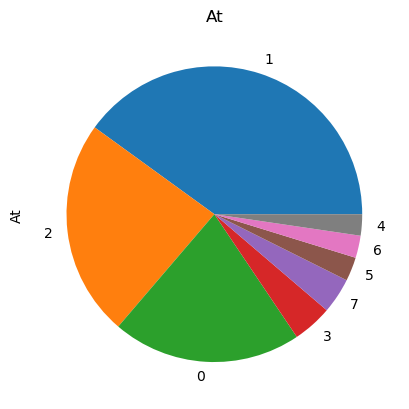

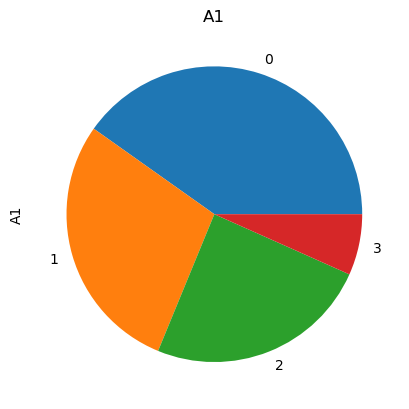

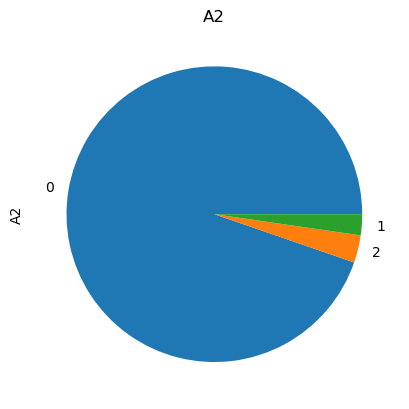

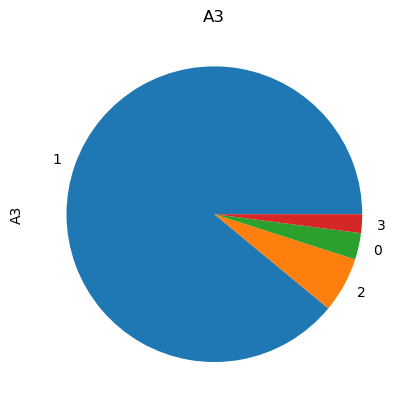

In [17]:
#plot pie distribution of all colummn of df_mdp_norm
for col in df_mdp_norm.columns:
    plt.figure()
    df_mdp_norm[col].value_counts().plot.pie()
    plt.title(col)
    plt.show()


## T with actions clustered

In [12]:
## NUOVO TENTATIVO

# assegna df_mdp_norm a dafr. se non è stato caricato, caricalo e assegnalo
try:
    dafr = df_mdp_norm
except NameError:
    dafr = pd.read_csv('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/df_mdp_norm.csv')


n_A = dafr['At'].max() + 1
[S, features] = dafr.shape
n_cluster = dafr['S'].max() + 1
T = np.zeros((n_cluster, n_cluster, n_A))

for s in range(S):

    s_cluster = dafr.loc[s, 'S']
    if s != S-1:
        s_prime = s + 1
    else:
        break
    
    
    s_cluster_prime = dafr.loc[s_prime-1, 'S']
    for a in range(n_A):
        T[int(s_cluster), int(dafr.loc[s_prime, 'S']), int(a)] += 1


for a in range(n_A):
    for s in range(n_cluster):
        sum_a_s = T[s,:,a].sum()
        if sum_a_s != 0:
            T[s,:,a] = T[s,:,a] / sum_a_s
        else:

#check if there is a nan in T
print("T sum: ", T.sum())
print("T nan: ", np.isnan(T).any())
print("T inf: ", np.isinf(T).any())
print("T max: ", np.max(T))


# Specifica il nome della directory cluster_model
cluster_model = 'At'

# Crea il percorso completo per la directory cluster_model
cluster_model_directory = '/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/T'

# Crea la directory cluster_model se non esiste
if not os.path.exists(cluster_model_directory):
    os.makedirs(cluster_model_directory)
    print("Directory", cluster_model, "creata con successo!")

# Salvataggio dell'array T nella directory cluster_model
T_file_path = os.path.join(cluster_model_directory, 'T_' + cluster_model + '.npy')
np.save(T_file_path, T)
    



T sum:  3375.9999999999986
T nan:  False
T inf:  False
T max:  1.0


In [13]:
T = np.load('/Users/edoardorossi/Documents/GitHub/Tesi/MDP_data/kmeans/T_a_clustered_kmeans_norm.npy')
print('T shape:', T.shape)

T shape: (422, 422, 8)


## T with actions clustered and discretized

In [10]:
## NUOVO TENTATIVO

dafr = df_norm.copy()
n_a1 = df_actions['F_M_FDBK_00'].max() + 1
n_a2 = df_actions['VLV_RAF_REG_00'].max() + 1
n_a3 = df_actions['VLV_SUR_REG_00'].max() + 1
n_A = n_a1 * n_a2 * n_a3

[S, features] = dafr.shape
n_cluster = clustering_model.n_clusters
T = np.zeros((n_cluster, n_cluster, n_A))

for s in range(S):

    s_cluster = dafr.loc[s, 'cluster']
    if s != S-1:
        s_prime = s + 1
    else:
        break
    
    
    s_cluster_prime = dafr.loc[s_prime-1, 'cluster']
    
    a_dis = [df_actions.loc[s, 'F_M_FDBK_00'], df_actions.loc[s, 'VLV_RAF_REG_00'], df_actions.loc[s, 'VLV_SUR_REG_00']]
    a = sub2ind3d((n_a1, n_a2, n_a3), a_dis)
    T[int(s_cluster), int(dafr.loc[s_prime, 'cluster']), int(a)] += 1


for a in range(n_A):
    sum_a = T[:, :, a].sum(axis=1)
    T[:, :, a] = T[:, :, a] / np.maximum(sum_a, 1e-6)[:, np.newaxis]#T[:, :, a].sum(axis=1)[:, np.newaxis]
    if np.isnan(T).any() == True:
        print("T contiene dei nan")

#check if there is a nan in T
print("T sum: ", T.sum())
print("T nan: ", np.isnan(T).any())
print("T inf: ", np.isinf(T).any())
print("T max: ", np.max(T))




# Specifica il nome della directory cluster_model
cluster_model = name_clustering_model

# Crea il percorso completo per la directory cluster_model
cluster_model_directory = path_save_matrix

# Crea la directory cluster_model se non esiste
if not os.path.exists(cluster_model_directory):
    os.makedirs(cluster_model_directory)
    print("Directory", cluster_model, "creata con successo!")

# Salvataggio dell'array T nella directory cluster_model
T_file_path = os.path.join(cluster_model_directory, 'T_clustered_actions' + cluster_model + '.npy')
np.save(T_file_path, T)
    



T sum:  818.999999999999
T nan:  False
T inf:  False
T max:  1.0
